# Fruits 360 dataset with PyTorch and Ignite

In this kernel I would like to present recently released the first version of high-level library [*ignite*](https://github.com/pytorch/ignite) to help training neural networks in PyTorch.


## Why to use *ignite* ?

- ignite helps you write compact but full-featured training loops in a few lines of code
- you get a training loop with metrics, early-stopping, model checkpointing and other features without the boilerplate

## Installation

Just run the following command:
```bash
pip install pytorch-ignite
```
or with conda
```bash
conda install ignite -c pytorch
```

The latest version can be installed from the [github](https://github.com/pytorch/ignite.git):
```bash
git clone https://github.com/pytorch/ignite.git
cd ignite && python setup.py install
```

In [2]:
# Let's install ignite as a custom package:
#!pip install git+https://github.com/pytorch/ignite.git --prefix=/kaggle/working
    
import sys
sys.path.insert(0, "/kaggle/working/lib/python3.6/site-packages")

Before we starts with *ignite*, let's define essential things: 
- dataflow :
    - train data loader
    - validation data loader
- model :
   - let's take a small network SqueezeNet 
- optimizer : 
   - let's take SGD
- loss function :
    - Cross-Entropy

In [27]:
from pathlib import Path

import numpy as np
import time
import tqdm
import torch
import shutil
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.transforms import ColorJitter, ToTensor, Normalize


FRUIT360_PATH = Path(".").resolve().parent / "input" / "fruits-360_dataset" / "fruits-360"

img_size = 64

device = "cuda"
if not torch.cuda.is_available():
    device = "cpu"

train_transform = Compose([
    RandomHorizontalFlip(),    
    RandomResizedCrop(size=img_size),
    ColorJitter(brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = Compose([
    RandomResizedCrop(size=img_size),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 128
num_workers = 8

train_dataset = ImageFolder((FRUIT360_PATH /"Training").as_posix(), transform=train_transform, target_transform=None)
val_dataset = ImageFolder((FRUIT360_PATH /"Test").as_posix(), transform=val_transform, target_transform=None)

pin_memory = "cuda" in device
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                          drop_last=True, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                        drop_last=False, pin_memory=pin_memory)


In [4]:
b = iter(val_loader).next()

In [5]:
data, labels = b

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\zjd19\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0,60,'Huckleberry')

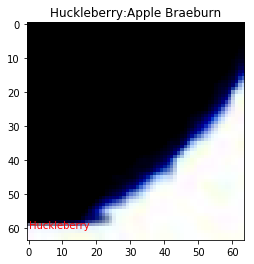

In [7]:
imshow(data[0].numpy().transpose(1,2,0))
predictions=[0]*len(labels)
title("{}:{}".format(val_dataset.classes[labels[0]], val_dataset.classes[predictions[0]]));
text(0, 60, val_dataset.classes[labels[0]], color='r')

In [8]:
print("PyTorch version: {} | Device: {}".format(torch.__version__, device))
print("Train loader: num_batches={} | num_samples={}".format(len(train_loader), len(train_loader.sampler)))
print("Validation loader: num_batches={} | num_samples={}".format(len(val_loader), len(val_loader.sampler)))

PyTorch version: 0.4.1 | Device: cuda
Train loader: num_batches=322 | num_samples=41322
Validation loader: num_batches=109 | num_samples=13877


In [9]:
import torch.nn as nn
from torchvision.models.squeezenet import squeezenet1_1
from torch.optim import SGD


In [10]:
model = squeezenet1_1(pretrained=False, num_classes=81)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)
model = model.to(device)

C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [11]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [14]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [20]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(val_loader)
    return eval_loss

In [23]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(model, val_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=model.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    0   loss:  1.68593  test-loss:  1.3193  time: 21.79273247718811                                               
Epoch    1   loss:  1.38756  test-loss:  1.2031  time: 22.37916350364685                                               
Epoch    2   loss:  1.16676  test-loss:  1.0694  time: 22.3131320476532                                                
Epoch    3   loss:  0.96536  test-loss:  1.067  time: 22.290401220321655                                               
Epoch    4   loss:  0.81528  test-loss:  0.664  time: 21.897452116012573                                               
Epoch    5   loss:  0.69820  test-loss:  0.60471  time: 21.883488416671753                                             
Epoch    6   loss:  0.61803  test-loss:  0.64471  time: 21.987212657928467                                             
Epoch    7   loss:  0.55259  test-loss:  0.50005  time: 22.602957248687744                                             
Epoch    8   loss:  0.48796  test-loss: 

In [26]:
predictions = np.zeros(len(val_dataset))
targets = np.zeros(len(val_dataset))

for i  in tqdm.tnrange(len(val_dataset)):
    x, t = val_dataset[i]
    p = model(x[None,...].cuda()).cpu().argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

NameError: name 'classification_report' is not defined

In [28]:
print(classification_report(targets, predictions, digits=3))

C:\Users\zjd19\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0      0.564     0.701     0.625       164
        1.0      0.976     0.976     0.976       164
        2.0      0.870     0.939     0.903       164
        3.0      0.956     0.801     0.872       161
        4.0      0.994     0.970     0.981       164
        5.0      0.833     0.762     0.796       164
        6.0      0.868     0.841     0.854       164
        7.0      0.937     0.826     0.878       144
        8.0      0.987     0.934     0.960       166
        9.0      0.925     0.982     0.953       164
       10.0      0.988     0.988     0.988       164
       11.0      1.000     0.986     0.993       143
       12.0      0.971     0.994     0.982       166
       13.0      0.880     0.970     0.923       166
       14.0      0.819     0.928     0.870       166
       15.0      0.957     0.946     0.952       166
       16.0      0.968     0.921     0.944       164
       17.0      0.916     1.000     0.956   

And let us begin

## Ignite quickstart with Fruits 360 dataset

### Engine

The base of the framework is `ignite.engine.Engine`, an object that loops a given number of times over provided data, executes a processing function and returns a result:
```python
while epoch < max_epochs:
    # run once on data
    for batch in data:
        output = process_function(batch)
```

So, a model trainer is simply an engine that loops multiple times over the training dataset and updates model parameters. 
Similarly, model evaluation can be done with an engine that runs a single time over the validation dataset and computes metrics.

In [8]:
from ignite.engine import Engine, _prepare_batch, create_supervised_trainer

def model_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(model_update)

and that's it. A trainer is setup, so we can just simply execute `run` method and our model will be silently trained. We could also use a helper method `ignite.engine.create_supervised_trainer` to create a trainer without explicitly coding `model_update` function:
```python
from ignite.engine import create_supervised_trainer

trainer = create_supervised_trainer(model, optimizer, criterion, device)
```


> **Note:** update function should have two inputs : `engine` and `batch`



Let's add more interaction with our created trainer:
- add logging of loss function value every 50 iterations
- run offline metrics computation on a subset of the training dataset
- run metrics computation on the validation dataset once epoch is finished
- checkpoint trained model every epoch
- save 3 best models
- add LR scheduling
- add early stopping

### Events and Handlers

In order to accomplish above todo list *ignite* provides an event system that facilitates interaction at each step of the run:
- *engine is started/completed*
- *epoch is started/completed*
- *batch iteration is started/completed*

So that user can execute a custom code as an event handler.

#### Training batch loss logging

We just define a function and add this function as a handler to the trainer. There are two ways to add a handler: via `add_event_handler`, via `on` decorator:

In [9]:
from ignite.engine import Events

log_interval = 50 
if 'cpu' in device:
    log_interval = 5 

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(train_loader) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}".format(engine.state.epoch, iteration, len(train_loader), engine.state.output))


The same can be done with `add_event_handler` like this:
```python
trainer.add_event_handler(Events.ITERATION_COMPLETED, log_training_loss)
```


> **Note:** handlers can also pass `args` and `kwargs`, so in general a handler can be defined as 

```python
    def custom_handler(engine, *args, **kwargs):
        pass

    trainer.add_event_handler(Events.ITERATION_COMPLETED, custom_handler, *args, **kwargs)
    # or 
    @trainer.on(Events.ITERATION_COMPLETED, *args, **kwargs)
    def custom_handler(engine, *args, **kwargs):
        pass
```

Let's see what happens if we run the trainer for a single epoch

In [10]:
output = trainer.run(train_loader, max_epochs=1)

Epoch[1] Iteration[50/322] Loss: 4.3810
Epoch[1] Iteration[100/322] Loss: 4.3448
Epoch[1] Iteration[150/322] Loss: 4.1856
Epoch[1] Iteration[200/322] Loss: 4.1766
Epoch[1] Iteration[250/322] Loss: 4.0662
Epoch[1] Iteration[300/322] Loss: 4.1234


Looks good! 

> add logging of loss function value every 50 iterations

Done!

#### Offline training metrics and validation metrics

Now let's add some code to compute metrics: average accuracy, precision, recall over a subset of the training dataset and validation dataset. What is *offline* training metrics and why ? By offline, I mean that we compute training metrics using a fixed model vs online when metrics are computed batchwise over model that keep changing every iteration.

At first we define metrics we want to compute:

In [11]:
from ignite.metrics import Loss, CategoricalAccuracy, Precision, Recall


metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': CategoricalAccuracy(),
    'avg_precision': Precision(average=True), 
    'avg_recall': Recall(average=True)
}

Next we can define engines using a helper method `ignite.engine.create_supervised_evaluator`:

In [12]:
from ignite.engine import create_supervised_evaluator

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

and we need to define a train subset and its data loader:

In [13]:
import numpy as np
from torch.utils.data.dataset import Subset

random_indices = np.random.permutation(np.arange(len(train_dataset)))[:len(val_dataset)]
train_subset = Subset(train_dataset, indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                               drop_last=True, pin_memory="cuda" in device)

Now let's define when to execute metrics computation and display results

In [14]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_eval_loader).metrics
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))
    
    
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))    

Let's check it again

In [15]:
output = trainer.run(train_loader, max_epochs=1)

Epoch[1] Iteration[50/322] Loss: 4.0652
Epoch[1] Iteration[100/322] Loss: 4.0529
Epoch[1] Iteration[150/322] Loss: 4.1045
Epoch[1] Iteration[200/322] Loss: 4.0165
Epoch[1] Iteration[250/322] Loss: 4.0605
Epoch[1] Iteration[300/322] Loss: 4.1414
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 4.0146 | Accuracy: 0.0468 | Precision: 0.0033 | Recall: 0.0382
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 4.0228 | Accuracy: 0.0472 | Precision: 0.0090 | Recall: 0.0419


Nice !

> run offline metrics computation on a subset of the training dataset

> run metrics computation on the validation dataset once epoch is finished

Done !

----

##### More details



Let's explain some details in the above code. Maybe you've remarked the following
```python
metrics = train_evaluator.run(train_eval_loader).metrics
```
and you have a question what is the object returned by `train_evaluator.run(train_eval_loader)` that has `metrics` as attribute. 

Actually, `Engine` contains a structure called `State` to pass data between handlers. Basically, `State` contains information on the current 
epoch, iteration, max epochs, etc and also can be used to pass some custom data, such as metrics. Thus, the above code can be rewritten as 
```python
state = train_evaluator.run(train_eval_loader)
metrics = state.metrics
# or just
train_evaluator.run(train_eval_loader)
metrics = train_evaluator.state.metrics
```

-----

#### Learning rate scheduling

There are several ways to perform learning rate scheduling with *ignite*, here we will use the most simple one by calling `lr_scheduler.step()` every epoch:

In [16]:
from torch.optim.lr_scheduler import ExponentialLR


lr_scheduler = ExponentialLR(optimizer, gamma=0.8)


@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Display learning rate:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))    

#### Training checkpointing

As we move on training, we would like to store the best model, last trained model, optimizer and learning rate scheduler. With *ignite* it is not a problem, there is a special class `ModelCheckpoint` for these purposes. 

Let's use `ModelCheckpoint` handler to store the best model defined by validation accuracy. In this case we define a `score_function` that provides validation accuracy to the handler and it decides (max value - better) whether to save or not the model.

In [17]:
from ignite.handlers import ModelCheckpoint


def score_function(engine):
    val_avg_accuracy = engine.state.metrics['avg_accuracy']
    # Objects with highest scores will be retained.
    return val_avg_accuracy


best_model_saver = ModelCheckpoint("best_models",  # folder where to save the best model(s)
                                   filename_prefix="model",  # filename prefix -> {filename_prefix}_{name}_{step_number}_{score_name}={abs(score_function_result)}.pth
                                   score_name="val_accuracy",  
                                   score_function=score_function,
                                   n_saved=3,
                                   atomic=True,  # objects are saved to a temporary file and then moved to final destination, so that files are guaranteed to not be damaged
                                   save_as_state_dict=True,  # Save object as state_dict
                                   create_dir=True, require_empty=False)

val_evaluator.add_event_handler(Events.COMPLETED, best_model_saver, {"best_model": model})

Now let's define another `ModelCheckpoint` handler to store trained model, optimizer and lr scheduler every 1000 iterations:

In [18]:
training_saver = ModelCheckpoint("checkpoint",
                                 filename_prefix="checkpoint",
                                 save_interval=1000,
                                 n_saved=1,
                                 atomic=True,
                                 save_as_state_dict=True,
                                 create_dir=True,require_empty=False)

to_save = {"model": model, "optimizer": optimizer, "lr_scheduler": lr_scheduler} 
trainer.add_event_handler(Events.ITERATION_COMPLETED, training_saver, to_save)

We are almost done with preparations and a cherry on top

#### Early stopping

Let's add another handler to stop training if model fails to improve a score defined by a `score_function` during 10 epochs:

In [19]:
from ignite.handlers import EarlyStopping

early_stopping = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

## Run training

Now we can just call `run` method and train model during a number of epochs 

In [20]:
max_epochs = 10

output = trainer.run(train_loader, max_epochs=max_epochs)

Learning rate: 0.01
Epoch[1] Iteration[50/322] Loss: 3.9986
Epoch[1] Iteration[100/322] Loss: 3.9961
Epoch[1] Iteration[150/322] Loss: 3.9193
Epoch[1] Iteration[200/322] Loss: 3.7791
Epoch[1] Iteration[250/322] Loss: 3.7589
Epoch[1] Iteration[300/322] Loss: 3.5512
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 3.4790 | Accuracy: 0.1126 | Precision: 0.0685 | Recall: 0.1055
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 3.4793 | Accuracy: 0.1100 | Precision: 0.0622 | Recall: 0.1055
Learning rate: 0.008
Epoch[2] Iteration[50/322] Loss: 3.3429
Epoch[2] Iteration[100/322] Loss: 4.1694
Epoch[2] Iteration[150/322] Loss: 3.3710
Epoch[2] Iteration[200/322] Loss: 3.0284
Epoch[2] Iteration[250/322] Loss: 3.0796
Epoch[2] Iteration[300/322] Loss: 3.0392
Compute train metrics...
Training Results - Epoch: 2  Average Loss: 3.0730 | Accuracy: 0.1451 | Precision: 0.1282 | Recall: 0.1385
Compute validation metrics...
Validation Results - Epoch: 2  Average 

ERROR:ignite.engine.engine.Engine:Current run is terminating due to exception: [WinError 183] 当文件已存在时，无法创建该文件。: 'C:\\Users\\zjd19\\Desktop\\cse470\\project1\\checkpoint\\tmpldzu6jnn' -> 'checkpoint\\checkpoint_model_3000.pth'
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: [WinError 183] 当文件已存在时，无法创建该文件。: 'C:\\Users\\zjd19\\Desktop\\cse470\\project1\\checkpoint\\tmpldzu6jnn' -> 'checkpoint\\checkpoint_model_3000.pth'


FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'C:\\Users\\zjd19\\Desktop\\cse470\\project1\\checkpoint\\tmpldzu6jnn' -> 'checkpoint\\checkpoint_model_3000.pth'

Let's check saved 3 best models and the checkpoint:

In [29]:
ls best_models\

 驱动器 C 中的卷是 Windows
 卷的序列号是 B6B2-FA74

 C:\Users\zjd19\Desktop\cse470\project1\best_models 的目录

2018/10/29  上午 10:28    <DIR>          .
2018/10/29  上午 10:28    <DIR>          ..
2018/10/24  下午 09:53         3,067,114 model_best_model_10_val_accuracy=0.8646682.pth
2018/10/28  下午 04:49         3,067,114 model_best_model_17_val_accuracy=0.8783599.pth
2018/10/28  下午 04:49         3,067,114 model_best_model_18_val_accuracy=0.8787202.pth
2018/10/28  下午 04:50         3,067,114 model_best_model_19_val_accuracy=0.8813865.pth
2018/10/29  上午 10:26         3,067,114 model_best_model_7_val_accuracy=0.6641205.pth
2018/10/29  上午 10:27         3,067,114 model_best_model_8_val_accuracy=0.7500901.pth
2018/10/24  下午 09:52         3,067,114 model_best_model_8_val_accuracy=0.8431938.pth
2018/10/29  上午 10:28         3,067,114 model_best_model_9_val_accuracy=0.7825899.pth
2018/10/24  下午 09:53         3,067,114 model_best_model_9_val_accuracy=0.8604886.pth
               9 个文件     27,604,026 字节
             

In [22]:
!ls checkpoint/

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


## Inference

Let's first create a test dataloader from validation dataset such that provided batch is composed of `(samples, sample_indices)`:

In [ ]:
class TestDataset(Dataset):
    
    def __init__(self, ds):
        self.ds = ds
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        return self.ds[index][0], index

    
test_dataset = TestDataset(val_dataset)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                         drop_last=False, pin_memory="cuda" in device)

With ignite to implement an engine that inference on data is simple. Similarly when we created an evaluation engine, now we modify the update function to store output results. We will also perform what is called test time augmentation (TTA).

In [ ]:
import torch.nn.functional as F
from ignite._utils import convert_tensor


def _prepare_batch(batch):
    x, index = batch
    x = convert_tensor(x, device=device)
    return x, index


def inference_update(engine, batch):
    x, indices = _prepare_batch(batch)
    y_pred = model(x)
    y_pred = F.softmax(y_pred, dim=1)
    return {"y_pred": convert_tensor(y_pred, device='cpu'), "indices": indices}

    
model.eval()
inferencer = Engine(inference_update)    

Next let's define a handler to log steps during the inference and a handler to store predictions

In [ ]:
@inferencer.on(Events.EPOCH_COMPLETED)
def log_tta(engine):
    print("TTA {} / {}".format(engine.state.epoch, n_tta))

    
n_tta = 3
num_classes = 81
n_samples = len(val_dataset)

# Array to store prediction probabilities
y_probas_tta = np.zeros((n_samples, num_classes, n_tta), dtype=np.float32)

# Array to store sample indices
indices = np.zeros((n_samples, ), dtype=np.int)
    

@inferencer.on(Events.ITERATION_COMPLETED)
def save_results(engine):
    output = engine.state.output
    tta_index = engine.state.epoch - 1
    start_index = ((engine.state.iteration - 1) % len(test_loader)) * batch_size
    end_index = min(start_index + batch_size, n_samples)
    batch_y_probas = output['y_pred'].detach().numpy()
    y_probas_tta[start_index:end_index, :, tta_index] = batch_y_probas
    if tta_index == 0:
        indices[start_index:end_index] = output['indices']

Before running the inference, we may want to load the best model from the storage:
```python
model = squeezenet1_1(pretrained=False, num_classes=64)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)  # Adapt the last average pooling to our data
model = model.to(device)

model_state_dict = torch.load("best_models/model_best_model_N_val_accuracy=0.XYZ.pth")
model.load_state_dict(model_state_dict)
```

In [28]:
inferencer.run(test_loader, max_epochs=n_tta)

BrokenPipeError: [Errno 32] Broken pipe

In [1]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


Final probability aggregation can be done using mean or gmean

In [ ]:
y_probas = np.mean(y_probas_tta, axis=-1)
y_preds = np.argmax(y_probas, axis=-1)

Next step can be to create a submission using `indices` and `y_probas`. Here we will just compute accuracy on our test=validation dataset

In [ ]:
from sklearn.metrics import accuracy_score

y_test_true = [y for _, y in val_dataset]

In [ ]:
accuracy_score(y_test_true, y_preds)

### Final words

That's all for this kernel. If you liked it - please upvote. 

If you liked *ignite*, please visit its [documentation site](https://pytorch.org/ignite/), [github code](https://github.com/pytorch/ignite) and checkout [examples](https://github.com/pytorch/ignite/tree/master/examples) with `tensorboard`, `visdom` integration and how to train dcgan. Some other examples can be found [here](https://github.com/vfdev-5/ignite-examples). 

We are actively working on it and appreciate all contributions and feedbacks. As always, PR are very welcome! 



In [ ]:
# Remove output to be able to commit
!rm -R best_models/ checkpoint/ lib/